# Power spectrum

## As a function of $\phi_1$

### Import data

In [3]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import scipy.integrate as integrate
from scipy.integrate import quad
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from scipy.signal import csd
import pandas as pd
from sympy import *
from sympy import symbols
from sympy import integrate
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import LogFormatter
from IPython.display import display, Image
import io
import os
# from mpi4py import MPI

import spectrum

In [4]:
# Retrieve num_data from environment variable in bash-script
num_data = int(os.getenv("num_data", "0"))  # Default = 0

In [5]:
# num_data = 0

In [6]:
# Chose subhalo profile
subhalo_profile = 'SIDM5_sph'

In [7]:
# Import data
simulation_data = pd.read_csv(f'../results/{subhalo_profile}/data_output_power_section{num_data}.csv')
phi_sim = simulation_data['x'].values

In [8]:
# Import data from the Ibata paper for the binning
data = pd.read_csv('../data/ibata/Ibata_Hist_Gaia.csv')
# count = data['y'].values
phi = data['x'].values

In [12]:
print(phi)

[  8.98612593   6.29669157   3.86339381   1.30202775  -1.00320171
  -3.56456777  -6.25400213  -8.68729989 -11.24866596 -13.68196371
 -16.24332978 -18.54855923 -21.2379936  -23.54322305 -26.10458911
 -28.53788687 -31.09925293 -33.660619   -36.09391676 -38.78335112
 -41.21664888 -43.77801494 -46.2113127  -48.64461046 -51.07790822
 -53.63927428 -56.07257204 -58.6339381  -61.19530416 -63.62860192
 -66.18996798 -68.62326574 -71.31270011 -73.61792956 -76.17929562
 -78.61259338 -81.30202775 -83.6072572  -86.16862327 -88.60192102]


### Bin the data

In [7]:
# As default we use the binning of Ibata for both phi and s
# Set number of bins
bin_number = 40  

# Calculate bin size
# x = np.array(phi_sim)
# bin_size = spectrum.calculate_bin_size_array(x, bin_number)

# print(bin_size)

In [8]:
# Create binning
bin_min = min(phi)
bin_size = 2.5
binning = spectrum.create_binning(bin_min, bin_size, bin_number)
# print(binning)

In [9]:
# Calculate bounds of the bins
binning_min, binning_max = spectrum.binning_bounds(binning, bin_size)
# print(binning_min), print(binning_max)

In [10]:
# Bin the data
counts_phi = spectrum.bin_data(phi_sim, binning_min, binning_max, bin_number)
# print(counts_phi)

### Calculate a fitting function

In [11]:
# Set the error
x = np.array(binning)
y = np.array(counts_phi)
x_err = np.full_like(x, 1.0)  # Uncertainty for x
y_err = np.sqrt(y) # Uncertainty for y
# x_err = 1.0
# y_err = 1.0

In [12]:
# Import fitting function

params, quadratic_fit = spectrum.quadratic_function(x, y, x_err, y_err)

In [13]:
# Plot results
# plt.scatter(x, y, label='Data')
# plt.errorbar(x, y, xerr=x_err, yerr=y_err, fmt='o', label='Data with error bars')
# plt.plot(x, quadratic_fit, color='red', label='Quadratic Fit')
# plt.xlabel(r'$\phi_1$ [deg]')
# plt.ylabel('Counts')
# plt.legend()
# plt.show()

# Print the parameters
# print("Parameters a, b, c:", params)

### Plot histogram

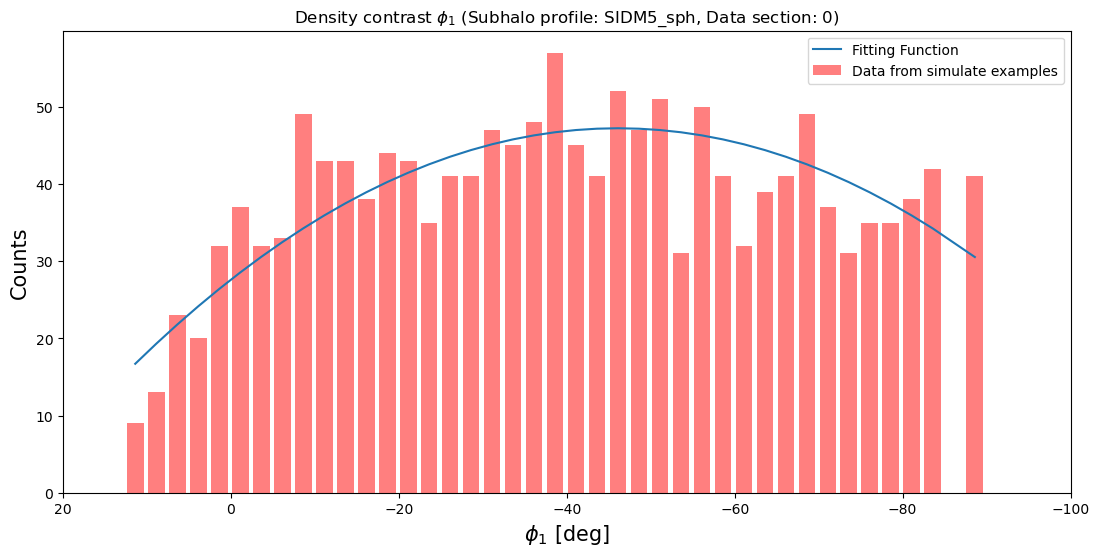

In [14]:
# Plot
plt.figure(figsize=(13,6))
plt.bar(binning, counts_phi,width=2, color='r',alpha=0.5, label = 'Data from simulate examples')
plt.plot(binning, quadratic_fit,label='Fitting Function')
plt.title(f'Density contrast $\phi_1$ (Subhalo profile: {subhalo_profile}, Data section: {num_data})')
# plt.plot(phi,fit_not_div,label='Fitting Function Ibata')
plt.xlim([20,-100])
plt.ylabel('Counts',size=15)
plt.xlabel(r'$\phi_1$ [deg]',size=15)
plt.legend()

# Save and show
plt.savefig(f'../results/{subhalo_profile}/density_contrast_phi1_section{num_data}.pdf')
plt.show()

### Calculate power spectrum

In [15]:
# Calculate density contrast
dens_fit = counts_phi/quadratic_fit

For the calculation of the power spectrum we use the CSD-algorithm by SciPy (see https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.csd.html) and set:

- *fs* = sympling frequency (1 divided by bin-size)
- *nperseg* = length of each segment (len(phi) = 40)

In [16]:
f_fit, pxx_fit = csd(dens_fit,dens_fit,fs=1/bin_size,scaling='spectrum',nperseg=bin_number)

In [17]:
# Calculate power
power = 1/f_fit
# print(power)

/tmp/ipykernel_24274/3188265607.py:2: RuntimeWarning: divide by zero encountered in divide
  power = 1/f_fit


### Plot and save power spectrum

In [18]:
# Save values for band plot
x = power  
y = 1 * np.sqrt(power[1] * np.array(pxx_fit))  

# Create data frame and save
data = pd.DataFrame({'x': x, 'y': y})
output_path = f'../results/{subhalo_profile}/power_spectrum_phi1_data_section{num_data}.csv'
data.to_csv(output_path, index=False)

In [19]:
# print(x)
# print(y)

[         inf 100.          50.          33.33333333  25.
  20.          16.66666667  14.28571429  12.5         11.11111111
  10.           9.09090909   8.33333333   7.69230769   7.14285714
   6.66666667   6.25         5.88235294   5.55555556   5.26315789
   5.        ]
[0.0230942  0.51772911 0.17585669 0.6416929  0.32727956 0.22636024
 0.25904458 0.20157337 0.20100613 0.12793969 0.64907396 0.60160071
 0.14578487 0.14737493 0.0861805  0.21387362 0.60530992 0.45534538
 0.17580684 0.36445622 0.13670033]


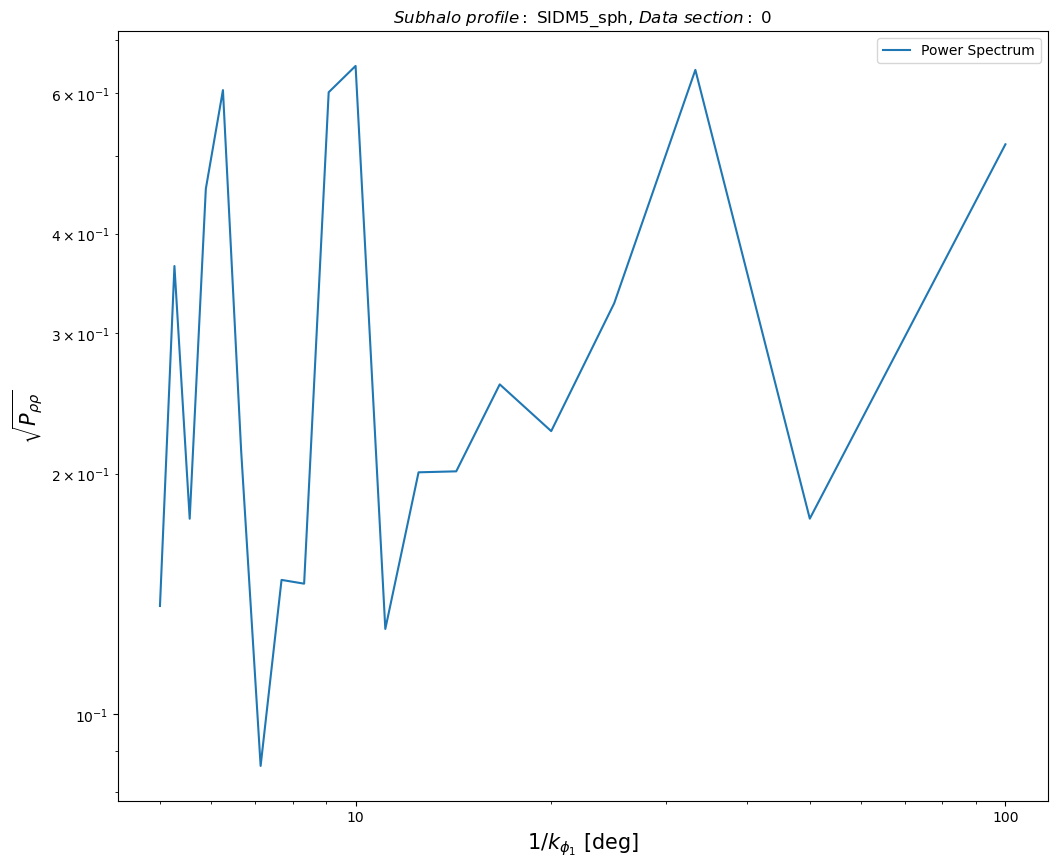

In [20]:
# Plot power spectrum 
### Plot 1/frequency and take the square root of the power * (phi[-1] - phi[0] = 97.5)
plt.figure(figsize=(12,10))
plt.loglog(power, 1*np.sqrt((power[1])*np.array(pxx_fit)),label='Power Spectrum')

plt.ylabel(r'$\sqrt{P_{\rho\rho}}$',size=15)
plt.xlabel(r'$1/k_{\phi_1}$ [deg]',size=15)
plt.gca().xaxis.set_major_formatter(LogFormatter(base=10, labelOnlyBase=True))
plt.legend()
plt.title(f'$Subhalo$ $profile:$ {subhalo_profile}, $Data$ $section:$ {num_data}')

# Save and show
plt.savefig(f'../results/{subhalo_profile}/power_spectrum_phi1_section{num_data}.pdf')
plt.show()

## As a function of s

### Create random values

We take the number of counts of every single bin of 𝜙1 and create an identical number of random values of $\phi_1$ within the range of each bin. These values are stored in a new array called random_phi.

In [21]:
# Generate random values

random_phi = spectrum.random_values(counts_phi, binning, bin_size)
# print(random_phi)

### Perform calculation from $\phi_1$ to s

In [22]:
s = spectrum.perform_integration(random_phi)

### Binning for s

In [31]:
# Calculate bin size of s
# bin_size_s = spectrum.calculate_bin_size_array(s, bin_number)

# Print bin size
# Print(bin_size_s)

In [23]:
# Calculate bin size from given bounds (Ibata's binning: min = -10.5, max = 1.5, number = 40)

binning_lower_limit = -10.5
binning_upper_limit = 1.5

bin_size_s = spectrum.calculate_bin_size_bounds(binning_lower_limit, binning_upper_limit, bin_number)

In [24]:
# Create bins for s (adjust minimum_s, if bounds manually chosen)

minimum_s = binning_lower_limit
binning_s = spectrum.create_binning(minimum_s, bin_size_s, bin_number)

# print(binning_s)
# print(len(binning_s))

In [25]:
# Calculate bounds of the bins
binning_s_min, binning_s_max = spectrum.binning_bounds(binning_s, bin_size_s)
# print(binning_s_min), print(binning_s_max)

In [26]:
# Assign the values to binning_s

counts_s = spectrum.bin_data(s, binning_s_min, binning_s_max, bin_number)
# print(counts_s)

### Calculate a fitting function

In [27]:
# Set the error
x = np.array(binning_s)
y = np.array(counts_s)
x_err = np.full_like(x, 1.0)  # Uncertainty for x
y_err = np.sqrt(y) # Uncertainty for y
# x_err = 1.0
# y_err = 1.0

In [28]:
# Import fitting function

params, quadratic_fit = spectrum.quadratic_function(x, y, x_err, y_err)

In [29]:
# Plot
# plt.scatter(x, y, label='Daten')
# plt.errorbar(x, y, xerr=x_err, yerr=y_err, fmt='o', label='Daten mit Fehlerbalken')
# plt.plot(x, quadratic_fit, color='red', label='Polynomialer Fit')
# plt.xlabel('s [kpc]')
# plt.ylabel('Counts')
# plt.legend()
# plt.show()

### Plot histogram

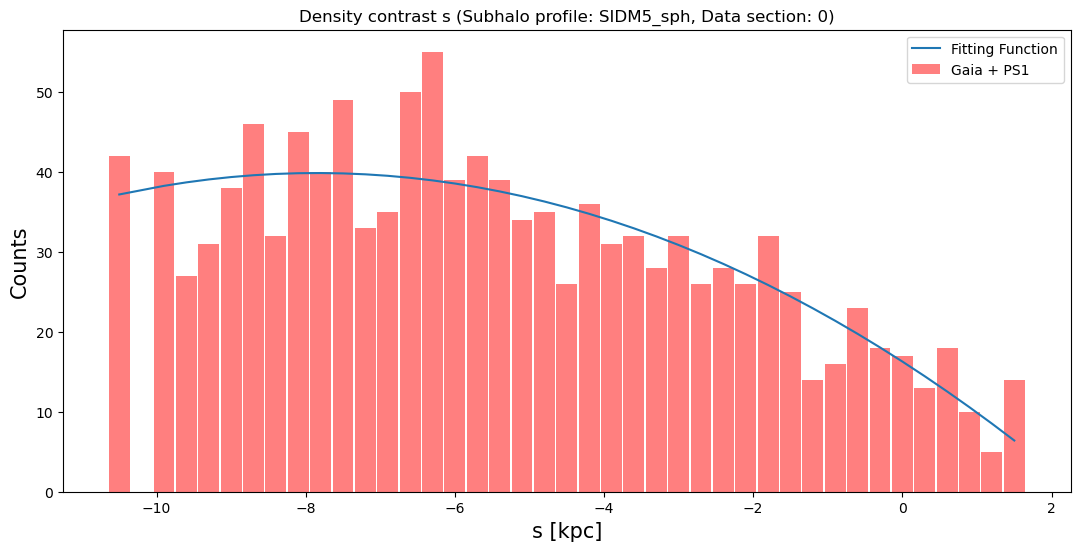

In [30]:
# Plot
plt.figure(figsize=(13,6))
plt.plot(binning_s, quadratic_fit, label='Fitting Function', zorder=2)
plt.bar(binning_s, counts_s, width=0.28,color='r',alpha=0.5,label = 'Gaia + PS1',zorder=1)
plt.title(f'Density contrast s (Subhalo profile: {subhalo_profile}, Data section: {num_data})')
# plt.plot(bins_s_ibata, quadratic_fit, label='Fitting Function', zorder=2)
# plt.bar(bins_s_ibata, counts_s_ibata, width=0.27,color='r',alpha=0.5,label = 'Gaia + PS1',zorder=1)
# plt.xlim([20,-100])
plt.ylabel('Counts',size=15)
plt.xlabel('s [kpc]',size=15)
plt.legend()

# Save and show
plt.savefig(f'../results/{subhalo_profile}/density_contrast_s_section{num_data}.pdf')
plt.show()

### Calculate power spectrum

We calculate the power spectrum with the CSD algorithm by SciPy (https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.csd.html) and define:

- *fs* = sampling frequency (set to 1/bin-size ~ 2.5)
- *nperseg* = length of each segment (set to len(phi) = 40)

In [31]:
# Calculate density contrast

dens_fit_s = counts_s/quadratic_fit

In [32]:
# Calculate the power spectrum 

f_fit, pxx_fit = csd(dens_fit_s,dens_fit_s,fs=1/bin_size_s,scaling='spectrum',nperseg=bin_number)

# f_fit_err, pxx_fit_err = csd(dens_fit_s_err,dens_fit_s_err, fs=1/0.4,scaling='spectrum',nperseg=40)
# pxx_fit_adj = (180/(np.pi))*pxx_fit
# I'm plotting 1/frequency and I'm taking the square root of the power * s[-1] - s[0] 
# which in this case was 16

In [33]:
# Calculate power
power = 1/f_fit
# print(power)

/tmp/ipykernel_24274/3188265607.py:2: RuntimeWarning: divide by zero encountered in divide
  power = 1/f_fit


In [34]:
# Save values for band plot
x = power  
y = 1 * np.sqrt(power[1] * np.array(pxx_fit))  

# Create data frame and save
data = pd.DataFrame({'x': x, 'y': y})
output_path = f'../results/{subhalo_profile}/power_spectrum_s_data_section{num_data}.csv'
data.to_csv(output_path, index=False)

In [35]:
# print(x)
# print(y)

/tmp/ipykernel_24274/2723617312.py:6: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0,10])


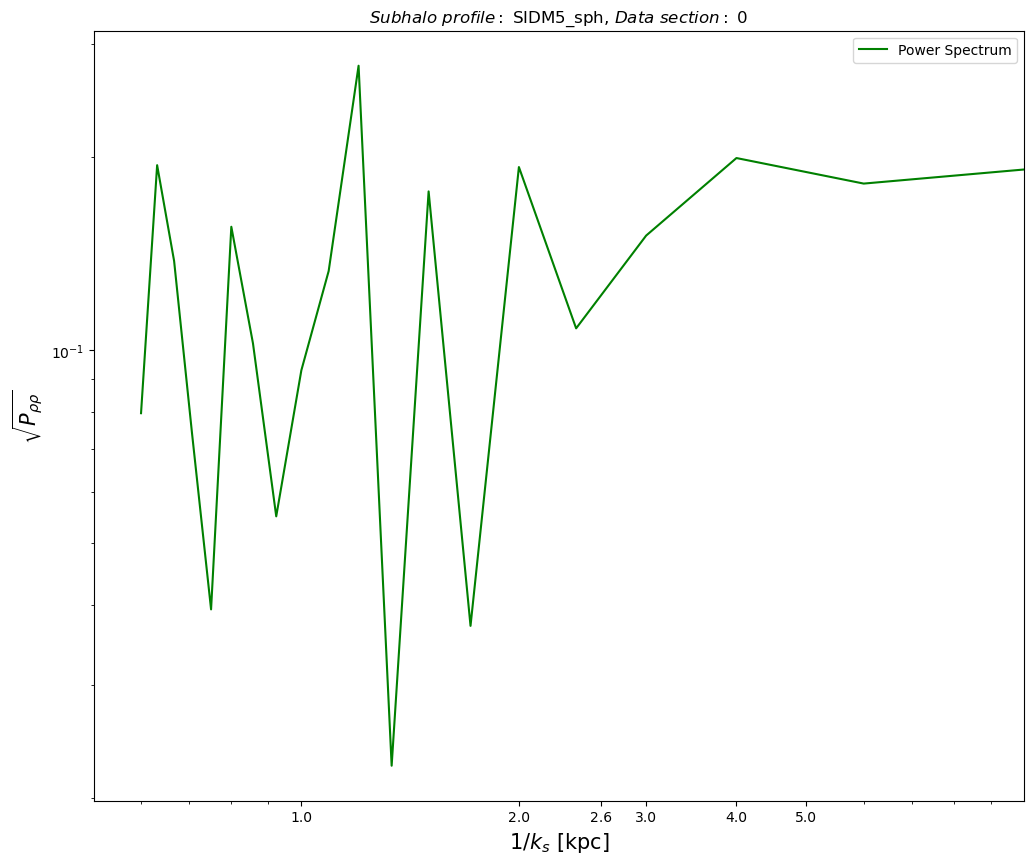

In [36]:
# Plot
plt.figure(figsize=(12,10))
plt.loglog(power, 1*np.sqrt(power[1]*np.array(pxx_fit)), color='green', label='Power Spectrum') # adjusted
plt.ylabel(r'$\sqrt{P_{\rho\rho}}$',size=15)
plt.xlabel(r'$1/k_{s}$ [kpc]',size=15)
plt.xlim([0,10])
plt.legend()
plt.title(f'$Subhalo$ $profile:$ {subhalo_profile}, $Data$ $section:$ {num_data}')

ax = plt.gca()
# ax.axvline(x=2.6, color='r', linestyle='--', linewidth=2)  # Linie bei x=2.6 einfügen
ax.set_xticks([1, 2, 2.6, 3, 4, 5])
ax.xaxis.set_major_formatter(ScalarFormatter())

# Save and show
plt.savefig(f'../results/{subhalo_profile}/power_spectrum_s_section{num_data}.pdf')
plt.show()